# **Adversarial Attacks Against Machine Learning-Based Spam Filters and Their Defense**

Team Members: **Kyle Wang**, **Brian Zhou**, **Jim Huang**

## **Introduction**
Machine learning-based spam detection models learn from a set of labeled training data and detect spam emails using this trained model. In this capstone, we study a class of vulnerabilities of such detection models, where the attack can manipulate the numerical features used in such a model ( e.g., TF-IDF vectors representing emails to a SVM classifier) to misclassify them during the detection phase. However, very often feature extraction methods make it difficult to translate a change made to the features to that in the textual email space. This lab uses a new attack method of making guided changes to the text in emails by taking advantage of purposely generated adversarial TF-IDF vetor representing emails. We identify a set of "magic words", or malicious words, to be added to a spam email, which can cause desirable misclassifications by classifiers. This attack works in a similar way to the so-called "good word attack".

For more information on this attack approach, you can refer to the following publications:

(1) Q. Cheng, A. Xu, X. Li, and L. Ding, “Adversarial Email Generation against Spam Detection Models through Feature Perturbation,” The 2022 IEEE International Conference on Assured Autonomy (ICAA’22), Virtual Event, March 22-23, 2022. [Download](https://isi.jhu.edu/wp-content/uploads/2022/04/Adversarial_Attacks_Against_Machine_Learning_Based_SpamFilters__IEEE.pdf)

(2) J. He, Q. Cheng, and X. Li, “Understanding the Impact of Bad Words 
on Email Management through Adversarial Machine Learning,” SIG-KM International Research Symposium 2021, Virtual Event, The University of North Texas, September 29, 2021. [Download](https://isi.jhu.edu/wp-content/uploads/2021/10/Bad-Words-He-Cheng-Li-Rev.pdf)

(3) C. Wang, D. Zhang, S. Huang, X. Li, and L. Ding, “Crafting Adversarial Email Content against Machine Learning Based Spam Email Detection,” In Proceedings of the 2021 International Symposium on Advanced Security on Software and Systems (ASSS ’21) with AsiaCCS 2021, Virtual Event, Hong Kong, June 7, 2021. [Download](https://isi.jhu.edu/wp-content/uploads/2021/04/ASSS_Workshop_Paper.pdf
) 

## **1. Loading Dataset**
We will be using the Ling-Spam. The Ling-Spam dataset is a collection of 2,893 spam and non-spam messages curated from Linguist List. The messages in the dataset revolve around linguistic interests, such as job postings, research opportunities and software discussion.

### Acknowledgements
The dataset and its information come from the original authors of "A Memory-Based Approach to Anti-Spam Filtering for Mailing Lists". The dataset was made publicly available as a part of that paper. \\

### Definition of each variables
x_train: Training data features

x_val  : Validation data features (This is used to find the magic words)

x_test : Testing data features

\\

y-train: Training data label

y_val  : Validation data label

y_test : Testing data label

**Run the code block below:**

In [1]:
import pandas as pd
import numpy as np

def create_subdatasets(percentage):

    df = pd.read_csv('./messages.csv', encoding='utf-8', encoding_errors='ignore')
    # Define the number of rows in the original dataset
    total_rows = len(df)
    print(len(df))
    
    # Calculate the number of rows for each subset
    subset1_size = 1000
    subset2_size = 1000
    
    # Calculate the number of rows for the common subset (20% of the total rows)
    common_size = int(percentage * subset1_size)
    print(common_size)

    # Randomly select rows for the common subset
    common_indices = np.random.choice(total_rows, common_size, replace=False)
    common_subset = df.iloc[common_indices]
    
    # Create a dataset without the rows already present in the common subset
    different_subset = df.drop(common_indices)
    
    # Create the first subset with 4000 rows and 20% common rows
    sub_dataset1_common = pd.concat([common_subset, different_subset.sample(subset1_size - common_size)])
    
    # Create the second subset with 12000 rows and 20% common rows
    sub_dataset2_common = pd.concat([common_subset, different_subset.sample(subset2_size - common_size)])
    
    return sub_dataset1_common, sub_dataset2_common


# # Example usage:
# # Assuming 'original_df' is your original dataset (DataFrame) with 16000 rows
# # Call the function to generate two sub-datasets
# df_shadow, df_target = create_subdatasets(0.5)

# # Output the sizes of the resulting sub-datasets
# print(f"Size of df_shadow: {len(df_shadow)}")
# print(f"Size of df_target: {len(df_target)}")

In [2]:
from tkinter import YView
from sklearn.model_selection import train_test_split

# This function extracts data from .csv file and split into training, validation, and testing dataset.
def data_extraction(df, valid = True):
  # Separate data into features and labels
  x = df.message
  y = df.label

  x = x.fillna('')
  y = y.fillna(0)
  x = x.astype(str)
  y = y.astype(int)

  # We first separate the entire dataset to 80% and 20%
  # We use the 90% to get our training dataset and the validation dataset. 
  # We use the 10% as our testing dataset. 
  x_train_val, x_test, y_train_val, y_test = train_test_split(x, y, test_size=0.1, random_state=99, stratify = y)

  # Separate the 80%, which contains our traning dataset and validation dataset, into another 80% traning dataset and 20% valications dataset.
  if valid:
    x_train, x_val, y_train, y_val = train_test_split(x_train_val, y_train_val, test_size=0.2, random_state=99, stratify=y_train_val)
  else:
    x_train, y_train = x_train_val, y_train_val

  return x_train, x_val, x_test, y_train, y_val, y_test

In [3]:
def copy_dataset_by_similarity(x_train, y_train, similarity = 0.2):
  # Reset the index to ensure default integer indexing
  x_train = x_train.reset_index(drop=True)
  y_train = y_train.reset_index(drop=True)

  # Calculate the shadow set size as 10% of the training set
  shadow_size = int(similarity * x_train.shape[0])

  # Create the shadow sets without using indices directly
  x_train_shadow = x_train.sample(n=shadow_size, random_state=99)
  y_train_shadow = y_train.loc[x_train_shadow.index]

  return x_train_shadow, y_train_shadow

In the code block above, we have read the dataset into variables 'messages' and 'labels'. Variable 'messages' contains the email messages and variable 'labels' contains the class labels where 0 represents ham and 1 represents spam.

We split the entire dataset into three different subsets: the training data, the validation data, and the testing data. 

In the code block above, we split the dataset twice using a 64:16:20 ratio, where 64% of the entire dataset is assigned to the training dataset (Y_train), 16% to the validation dataset (X_val), and 20% to the testing dataset (X_test), .

### **Additional Information of Three Datasets**
In the above operation, we divided the entire dataset into three parts: training dataset, validation dataset, and testing dataset. This is done to evaluate the performance of our machine learning model on new and unseen data. The training dataset is used to train the model, the validation dataset is used to tune the model's hyperparameters(magic words in our application), and the testing dataset is used to evaluate the final performance of the model. 

For more information on these concepts, you can read the article available at the following link: https://towardsdatascience.com/train-validation-and-test-sets-72cb40cba9e7.

## **2. Preprocessing the Emails**
To extract only useful information from the emails we used, we applied serveral data preprocessing steps.

(1). We removed all HTML tags, numbers, punctuation marks, and English stop words. 

(2). We converted all words to their lowercase forms and combined each paragraph into a single line instead of multiple lines. 

(3). We conducted stemming on all the remaining words to reduce them to their root forms. \\

**Run the code below:**

In [4]:
import re
import nltk
import string
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction._stop_words import ENGLISH_STOP_WORDS
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer


# Download required packages from nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

# Clean up the text data.
def remove_hyperlink(word):
    return re.sub(r"http\S+", " ", word)

# Convert the letter to lowercase.
def to_lower(word):
    result = word.lower()
    return result

# Remove the numbers.
def remove_number(word):
    result = re.sub(r'\d+', ' ', word)
    return result

# Remove the puncturations.
def remove_punctuation(word):
    result = word.translate(str.maketrans(dict.fromkeys(string.punctuation)))
    return result

# Remove the whitespace. 
def remove_whitespace(word):
    result = word.strip()
    return result

# Merge multiple lines into one line.
def replace_newline(word):
    return word.replace('\n', ' ')


def clean_up_pipeline(sentence):
    cleaning_utils = [remove_hyperlink,replace_newline,to_lower, remove_number, remove_punctuation, remove_whitespace]
    for o in cleaning_utils:
        sentence = o(sentence)
    return sentence

# Remove the stopwords, for example: a, and, an, above, ..., etc.
def remove_stop_words(words):
    result = [i for i in words if i not in ENGLISH_STOP_WORDS]
    return result

# Stemming aims to cut off the ends of words to obtain the root form. 
# It does not consider the meaning of the word. As a result, the stemmed word might not be a valid word in the language.
# Generally faster than lemmatization because it's based on rules and doesn't require additional resources like a lexicon.
# Example: "running" → "run", "flies" → "fli", "happily" → "happili"
def word_stemmer(words):
    stemmer = PorterStemmer()
    return [stemmer.stem(o) for o in words]

# Lemmatization reduces words to their base or dictionary form by considering the meaning and context of the word. 
# It ensures that the root word (lemma) is a valid word in the language.
# Generally more accurate than stemming but can be slower because it involves looking up words in a lexicon.
# Example: "running" → "run", "flies" → "fly", "better" → "good"
def word_lemmatizer(words):
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(o) for o in words]

# Clear out the unnecessary information.
def clean_token_pipeline(words):
    cleaning_utils = [remove_stop_words, word_lemmatizer]
    for o in cleaning_utils:
        words = o(words)
    return words

# Preprocess the text data.
def preprocess(X_train, X_val, X_test):
    print(f'Remove hyperlink...')
    print(f'Merge into one line...')
    print(f'Convert to lowercase...')
    print(f'Remove number...')
    print(f'Remove punctuation...')
    print(f'Remove whitespace...')
    x_train = [clean_up_pipeline(o) for o in X_train]
    x_val = [clean_up_pipeline(o) for o in X_val]
    x_test = [clean_up_pipeline(o) for o in X_test]
    
    print(f'Word Tokenize...')
    # word_tokenize() function is used to split a sentence or paragraph into individual words.
    x_train = [word_tokenize(o) for o in x_train]
    x_val = [word_tokenize(o) for o in x_val]
    x_test = [word_tokenize(o) for o in x_test]

    print(f'Remove stop words...')
    print(f'Lemmatize...')
    x_train = [clean_token_pipeline(o) for o in x_train]
    x_val = [clean_token_pipeline(o) for o in x_val]
    x_test = [clean_token_pipeline(o) for o in x_test]

    x_train = [" ".join(o) for o in x_train]
    x_val = [" ".join(o) for o in x_val]
    x_test = [" ".join(o) for o in x_test]    

    return x_train, x_val, x_test

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\31360\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\31360\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\31360\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


## **3. Feature Extraction**
In this step, we aim to transform the text content of an email into a numerical feature vector that captures the essential information used for classification. To achieve this, we can choose from a variety of vectorization techniques(TF-IDF and a modified Word2vec) that convert text data into numerical vectors. 

**Run the code block below:**

In [5]:
import gensim
!pip install --upgrade gensim
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec
import numpy as np
import pandas as pd
from scipy import sparse
from sklearn.preprocessing import MinMaxScaler


def TfidfConvert(x_train, x_test, x_val, vectorizer):

    raw_sentences = x_train + x_val
    
    # Learn vocabulary and compute IDF values. This vocabulary will be used later to convert new sentences into vectors.
    # Calculate IDF values for each word, store this information for later use during the transformation of text into vectors.
    # IDF(Inverse Document Frequency) is a measure of how important a word is to the entire corpus. 
    # Words that are frequent in a specific document but rare across the entire dataset will have a high IDF weight, vice versa.
    vectorizer.fit(raw_sentences)
    
    # vectorizer.transform() is used to convert raw text data into a numerical format suitable for ML algorithms. 
    # Calculate the frequency of each word，which is the term frequency (TF) part of the TF-IDF. 
    # Calculate the final TF-IDF weight for a word in a specific document, which is the product of its TF and IDF values. 
    x_train_features = vectorizer.transform(x_train)
    x_test_features = vectorizer.transform(x_test)
    x_val_features = vectorizer.transform(x_val)

    return x_train_features, x_test_features, x_val_features


def getUniqueWords(allWords):
    uniqueWords = []
    for i in allWords:
        if i not in uniqueWords:
            uniqueWords.append(i)
    return uniqueWords


def input_split(x):
    new_x = []
    for line in x:
        newline = line.split(' ')
        new_x.append(newline)
    return new_x


def getUniqueWords(allWords):
    uniqueWords = []
    for i in allWords:
        if i not in uniqueWords:
            uniqueWords.append(i)
    return uniqueWords


def x2vec(input_x, feature_names, model):
    x_features = []
    for index in input_x:
        model_vector = [0] * len(feature_names)

        for token in index:
            if token in feature_names:
                feature_index = feature_names.index(token)

                if model.wv.has_index_for(token):
                    token_vecs = model.wv.get_vector(token)
                    model_vector[feature_index] = token_vecs[0]
        x_features.append(model_vector)
    return x_features


def single_transform(x, method, feature_model, feature_names, scaler, selection_model):
    if method == 'tfidf':
        result = feature_model.transform(x)

        if selection_model != 'NaN':
            result = selection_model.transform(result)
        return result
    else:
        temp_x = x.values
        temp_x = temp_x[0].split(' ')
        model_vector = [0] * len(feature_names)
        for token in temp_x:
            if token in feature_names:
                feature_index = feature_names.index(token)
                if feature_model.wv.has_index_for(token):
                    token_vecs = feature_model.wv.get_vector(token)
                    model_vector[feature_index] = token_vecs[0]
        x_features = [model_vector]
        # x_features = np.array(x_features)
        x_features = scaler.transform(x_features)
        x_train_features = sparse.csr_matrix(x_features)
        if selection_model != 'NaN':
            x_train_features = selection_model.transform(x_train_features)
        return x_train_features


def feature_extraction(x_train, x_test, x_val, method):
    vectorizer = TfidfVectorizer()

    if method == 'tfidf':
        x_train_features, x_test_features, x_val_features = TfidfConvert(x_train, x_test, x_val, vectorizer)
        feature_names = vectorizer.get_feature_names()

        return x_train_features, x_test_features, x_val_features, feature_names, vectorizer, 'NaN'

    if method == 'word2vec':
        temp_x_train = input_split(x_train)
        temp_x_test = input_split(x_test)
        temp_x_val = input_split(x_val)

        model_train = Word2Vec(temp_x_train, vector_size=1)
        feature_space = []
        for index in temp_x_train:
            feature_space = feature_space + getUniqueWords(index)
        feature_names = getUniqueWords(feature_space)
      
        x_train_features = x2vec(temp_x_train, feature_names, model_train)
        x_test_features = x2vec(temp_x_test, feature_names, model_train)
        x_val_features = x2vec(temp_x_val, feature_names, model_train)

        x_train_features = np.array(x_train_features)
        x_test_features = np.array(x_test_features)
        x_val_features = np.array(x_val_features)

        pd.DataFrame(x_train_features).to_csv("x_train_features.csv", header=None, index=False)
        pd.DataFrame(x_test_features).to_csv("x_test_features.csv", header=None, index=False)
        pd.DataFrame(x_val_features).to_csv("x_val_features.csv", header=None, index=False)

        scaler = MinMaxScaler()
        scaler.fit(x_train_features)
        x_train_features = scaler.transform(x_train_features)
        x_test_features = scaler.transform(x_test_features)
        x_val_features = scaler.transform(x_val_features)

        x_train_features = sparse.csr_matrix(x_train_features)
        x_test_features = sparse.csr_matrix(x_test_features)
        x_val_features = sparse.csr_matrix(x_val_features)

        return x_train_features, x_test_features, x_val_features, feature_names, model_train, scaler

## **4. Training Classifiers**
In this section, we will train a Support Vector Machine (SVM) or Logic Regression (LR) as an spam filter.

**Run the code block below:**

In [6]:
!pip install secml
from secml.data import CDataset
from secml.data.splitter import CDataSplitterKFold
from secml.ml.classifiers import CClassifierSVM
from secml.ml.peval.metrics import CMetricAccuracy
from secml.ml.peval.metrics import CMetricConfusionMatrix
from secml.adv.attacks.evasion import CAttackEvasionPGD
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
# from Feature_extraction import single_transform
import csv
from statistics import mean, stdev
import threading
import time
import matplotlib.pyplot as plt
import seaborn as sns

def plot_confusion_matrix(cm, title='Confusion Matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    """
    classes = ['Negative', 'Positive']
    plt.figure(figsize=(3, 3))
    sns.heatmap(cm, annot=True, fmt="d", cmap=cmap, xticklabels=classes, yticklabels=classes)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title(title)
    plt.show()
    
def print_cm(cm):
    print(f'[TN   FP]')
    print(f'[FN   TP]')
    TN = cm[0, 0].item()
    FP = cm[0, 1].item()
    FN = cm[1, 0].item()
    TP = cm[1, 1].item()

    print("True Negatives (TN):", TN)
    print("False Positives (FP):", FP)
    print("False Negatives (FN):", FN)
    print("True Positives (TP):", TP)

    FNR = FN / (FN + TP)
    print("False Negative Rate (FNR = FN / (FN + TP)): {:.2%}".format(FNR))

def train_SVM(x_train_features, x_test_features, x_val_features, y_train, y_test, y_val):
    print("Start training SVM:")
    
    # Create a dataset object that combines data and label so that they're organized and ready for SVM to learn form.
    tr_set = CDataset(x_train_features, y_train)
    v_set = CDataset(x_val_features, y_val)
    test_set = CDataset(x_test_features, y_test)
    
    # Divide data into "folds" or chunks for cross-validation
    # It is conducive for training and testing the classifier on different subsets of the data.
    xval_splitter = CDataSplitterKFold()
    
    # Setting up an SVM classifier
    clf_lin = CClassifierSVM()
    
    # 'C' controls the trade-off between getting as many training points correctly classified as possible 
    # and finding the widest possible decision margin (or the gap between data points from different classes).
    xval_lin_params = {'C': [0.1, 1, 10, 100]}
    
    # Try out the 'C' on different parts of data to see which gives the best accuracy.
    best_lin_params = clf_lin.estimate_parameters( 
        dataset=tr_set,
        parameters=xval_lin_params,
        splitter=xval_splitter,
        metric='accuracy',
        perf_evaluator='xval'   # adopt Cross-Validation
    )
    
    print("The best training parameters are: ", 
          [(k, best_lin_params[k]) for k in sorted(best_lin_params)])
    
    # Use the best parameterer to train the classifiler
    clf_lin.fit(tr_set.X, tr_set.Y)

    # Use trained classifier to predict the validation data, calculate the accuracy of the valadation data
    y_pred = clf_lin.predict(test_set.X)
    metric = CMetricAccuracy()
    acc = metric.performance_score(y_true=test_set.Y, y_pred=y_pred)
    print(f'Validation Accuracy: {acc * 100}%')
    
    # Calculate and plot the confusion matrix of validation data
    confusion_matrix = CMetricConfusionMatrix()
    cm = confusion_matrix.performance_score(y_true=test_set.Y, y_pred=y_pred)
    plot_confusion_matrix(np.array(cm.tondarray()))

    print_cm(cm)
    return tr_set, v_set, clf_lin

In [7]:
from secml.data import CDataset
from secml.ml.classifiers import CClassifierLogistic
from secml.ml.features import CNormalizerMinMax
from secml.ml.peval.metrics import CMetricAccuracy
from secml.array import CArray

def train_LR(x_train_features, x_test_features, x_val_features, y_train, y_test, y_val):
    print("Start training Logistic Regression:")
    
    # Create a dataset object that combines data and label so that they're organized and ready for Logistic Regression to learn from.
    tr_set = CDataset(x_train_features, y_train)
    v_set = CDataset(x_val_features, y_val)
    test_set = CDataset(x_test_features, y_test)

    # Setting up a Logistic Regression classifier
    lr_classifier = CClassifierLogistic()

    # Train the classifier
    lr_classifier.fit(tr_set.X, tr_set.Y)

    # Use trained classifier to predict the validation data, calculate the accuracy of the validation data
    y_pred = lr_classifier.predict(test_set.X)
    metric = CMetricAccuracy()
    acc = metric.performance_score(y_true=test_set.Y, y_pred=y_pred)
    print(f'Validation Accuracy: {acc * 100}%')
    
    # Calculate and plot the confusion matrix of validation data
    confusion_matrix = CMetricConfusionMatrix()
    cm = confusion_matrix.performance_score(y_true=test_set.Y, y_pred=y_pred)
    plot_confusion_matrix(np.array(cm.tondarray()))
    print_cm(cm)

    return tr_set, v_set, lr_classifier


## **5. PGD Attack**
Our approach is based on successful adversarial perturbations made to model input features. We employ the Projected Gradient Descent (PGD) method to modify numeric feature values in the feature domain. PGD algorithm iteratively finds the needed changes with a constraint, *dmax*, which is the Euclidean distance to the original features indicating the allowed level of perturbations, to achieve the maximum loss in classification. In our approach, we run PGD over a set of spam emails and generate adversarial examples. Then we test these modified feature vectors to see whether they could successfully bypass the detection (i.e., being classified as ham).

**Run the code block below:**

In [8]:
def pgd_attack(clf_lin, tr_set, v_set, y_val, feature_names, nb_attack, dmax, lb, ub):

    class_to_attack = 1
    cnt = 0  # the number of success adversaril examples

    ori_examples2_x = []
    ori_examples2_y = []

    # Randomly select samples from the validation dataset for the attack.
    # The reason why choose validation dataset:
    #  - Test the model's ability to handle adversarial inputs that are as realistic as possible, 
    #  - mimicking the behavior it would need to handle in the real world.
    for i in range(nb_attack):
        # looking for indices of elements where y_val is equal to class_to_attack.
        idx_candidates = np.where(y_val == class_to_attack)
        # Randomly select a samples
        rn = np.random.choice(idx_candidates[0].size, 1)
        x0, y0 = v_set[idx_candidates[0][rn[0]], :].X, v_set[idx_candidates[0][rn[0]], :].Y

        x0 = x0.astype(float)
        y0 = y0.astype(int)
        x2 = x0.tondarray()[0]
        y2 = y0.tondarray()[0]

        ori_examples2_x.append(x2)
        ori_examples2_y.append(y2)

    # Setting parameters for PGD attack
    solver_params = {
        'eta': 0.01,
        'max_iter': 1000,
        'eps': 1e-4}
    
    # Type of perturbation 'l1' or 'l2'
    noise_type = 'l2'  
    y_target = 0
    
    # Initialize the PGD attack
    pgd_attack = CAttackEvasionPGD(
        classifier=clf_lin,
        double_init_ds=tr_set,
        distance=noise_type,
        dmax=dmax,
        lb=lb, ub=ub,
        solver_params=solver_params,
        y_target=y_target
    )

    ad_examples_x = []    # adversarial examples
    ad_examples_y = []    # predicted labels
    ad_index = []         # indices of successful adversarial attacks
    cnt = 0               # the number of successful adversarial examples
    for i in range(len(ori_examples2_x)):
        x0 = ori_examples2_x[i]
        y0 = ori_examples2_y[i]
        
        # y_pred_pgd  - The predicted label of the adversarial example.
        # adv_ds_pgd  - The adversarially perturbed data generated by the PGD attack
        y_pred_pgd, _, adv_ds_pgd, _ = pgd_attack.run(x0, y0)
        
        # Check Attack Success
        if y_pred_pgd.item() == 0:
            cnt = cnt + 1
            ad_index.append(i)

        ad_examples_x.append(adv_ds_pgd.X.tondarray()[0])
        ad_examples_y.append(y_pred_pgd.item())

        #attack_pt = adv_ds_pgd.X.tondarray()[0]

    print('Success rate of PGD(validation): {:.2f}%'.format((cnt / nb_attack) * 100))


    startTime2 = time.time()
    
    # Convert Lists to Arrays
    ori_examples2_x = np.array(ori_examples2_x)
    ori_examples2_y = np.array(ori_examples2_y)
    ad_examples_x = np.array(ad_examples_x)
    ad_examples_y = np.array(ad_examples_y)
     
    # Creates pandas DataFrames from the NumPy arrays of original and adversarial examples
    ori_dataframe = pd.DataFrame(ori_examples2_x, columns=feature_names)
    ad_dataframe = pd.DataFrame(ad_examples_x, columns=feature_names)

    # Adds the adversarial labels
    ad_dataframe['ad_label'] = ad_examples_y
    # Separate out the successful and failed adversarial attacks 
    ad_success = ad_dataframe.loc[ad_dataframe.ad_label == 0]
    ori_success = ori_dataframe.loc[ad_dataframe.ad_label == 0]
    ad_fail = ad_dataframe.loc[ad_dataframe.ad_label == 1]
    ori_fail = ori_dataframe.loc[ad_dataframe.ad_label == 1]

    ad_success_x = ad_success.drop(columns=['ad_label'])
    ad_fail_x = ad_fail.drop(columns=['ad_label'])

    result = (ad_success_x - ori_success)
    ori_dataframe.to_csv('ori_dataframe.csv')
    ad_dataframe.to_csv('ad_dataframe.csv')
    result.to_csv('result.csv')
    
    return result, cnt, ad_success_x, ori_dataframe, ori_examples2_y, cnt/nb_attack

## **6. Magical Words**
Adversarial emails are crafted by adding “magic words” to the original spam emails. The “magic words” are identified by intersecting the unique ham words with the “top words” identified during the adversarial perturbations. Specifically, the unique ham words are the words that only appear in ham emails but not in spam emails. After the PGD attack on the set of spam emails, we find which features are modified to the largest extent to bypass the detection. We then select a list of “top words” whose feature values have been changed the most. (The changes are measured by the variance of differences before and after the PGD perturbation.) In our experiments, we use the top 100 words, which is efficient. This set is relatively small and demonstrates a high success rate with the resulting magic words to fool the classifier. 

**Run the code block below:**

In [31]:
def magical_word(x_train, x_val, x_test, y_train, y_val, y_test, result, cnt):
    x2result1 = result
    x2result1 = np.array(x2result1)
    x2result = result
    x2result = x2result.multiply(x2result1)
    
    # Save the top 100 features to the x2result.csv
    sum_number = x2result.sum() / cnt
    sum_number = pd.DataFrame(sum_number, columns=['sum_number'])
    sum_number = sum_number.sort_values(
        by='sum_number', ascending=False, inplace=False)
    sum_number_pd = pd.DataFrame(sum_number.index[:100])
    sum_number_pd.to_csv("x2result.csv")
    
    # combine training and validation messages
    d = {'message': x_train, 'label': y_train}
    df = pd.DataFrame(data=d)
    d1 = {'message': x_val, 'label': y_val}
    df1 = pd.DataFrame(data=d1)
    frames = [df, df1]
    messages = pd.concat(frames)
    messages.to_csv("messages_train_val.csv")
    spam = messages[messages.label == 1]
    ham = messages[messages.label == 0]
    
    d2 = {'message': x_test, 'label': y_test}
    df2 = pd.DataFrame(data=d2)
    frames2 = [df2]
    messages_test = pd.concat(frames2)
    messages_test.to_csv("messages_test.csv")
    spam_test = messages_test[messages_test.label == 1]

    # Tf-idf for spam datasets
    vect_spam = TfidfVectorizer()
    vect_spam.fit_transform(spam['message'])
    header_spam = vect_spam.get_feature_names_out()

    # Tf-idf for ham datasets
    vect_ham = TfidfVectorizer()
    vect_ham.fit_transform(ham['message'])
    header_ham = vect_ham.get_feature_names_out()

    # find unique ham words
    ham_unique = list(set(header_ham).difference(set(header_spam)))
    header_ham1 = pd.DataFrame(ham_unique)
    header_ham1.to_csv("ham_unique.csv")
    

    # Find the intersection of the unique ham words and the top 100 features, 
    # It indicates important words that are unique to ham messages.
    with open("x2result.csv", "r") as csvfile:
        reader = csv.reader(csvfile)
        top100_features = []
        for row in reader:
            top100_features.append(row[1])
    top100_features = top100_features[1:]    
    
    ham_unique_in_top = list(set(ham_unique).intersection(set(top100_features)))
    
    words14str = ""
    for item in ham_unique_in_top:
        words14str = words14str + " " + item
    return words14str, spam, ham, spam_test

## **7. Crafting Adversarial Emails & Attacking SVM**
We can insert the identified "magic words" to original spam emails. This proccess is what we called "crafting adversarial emails". Then, we feed the new feature vectors of these crafted emails to the SVM classifier to see if they can be misclassified as ham emails.

**Run the code block below:**

In [35]:
from concurrent.futures import ThreadPoolExecutor, as_completed

m2_empty = pd.DataFrame()
spam_cnt = 0
threads = []
m2_empty_l1 = pd.DataFrame()
m2_empty_l2 = pd.DataFrame()
m2_empty_l3 = pd.DataFrame()
m2_empty_l4 = pd.DataFrame()
m2_list = [m2_empty_l1, m2_empty_l2, m2_empty_l3, m2_empty_l4]

class myThread(threading.Thread):

    def __init__(self, threadID, name, spam_message, words14str, method, feature_model, feature_names, scaler, clf_lin, list_index, selection_model):
        threading.Thread.__init__(self)
        self.threadID = threadID
        self.name = name
        self.spam_message = spam_message
        self.words14str = words14str
        self.method = method
        self.feature_model = feature_model
        self.feature_names = feature_names
        self.scaler = scaler
        self.clf_lin = clf_lin
        self.list_index = list_index
        self.lock = threading.Lock()
        self.selection_model = selection_model

    def run(self):
        global spam_cnt  # Count the number of successful attacks (spam messages that are misclassified as ham).
        print("Starting " + self.name)
        spam_cnt_1 = m2_empty_out(self.name, self.spam_message, self.words14str, self.method,
                                  self.feature_model, self.feature_names, self.scaler, self.clf_lin,
                                  self.list_index, self.selection_model)
        spam_cnt = spam_cnt+spam_cnt_1
        print("spam_cnt:", spam_cnt)
        time.sleep(0.1)
        print("Exiting " + self.name)

# Crafting Email
def m2_empty_out(name, spam_message, words14str, method, feature_model, feature_names, scaler, clf_lin, list_index, selection_model):
    m2_empty_1 = pd.DataFrame()  # Store messages that successfully deceived the model
    spam_cnt_1 = 0               # The number of successful deceptions
    global m2_list               # Store results from different threads
    
    for j in spam_message.message:
        choose_email = [j + words14str]                                    # append magic words
        message_14_email = pd.DataFrame(choose_email, columns=["message"]) # Adversarial Email
        message_14_tf_idf = single_transform(                              # Convet email to vector
            message_14_email["message"], method, feature_model, feature_names, scaler, selection_model)

        message_14_tf_idf = pd.DataFrame(
            message_14_tf_idf.toarray(), columns=feature_names)
        message_14_y = [1]
        message_14_y = pd.Series(message_14_y)
        message_CData = CDataset(message_14_tf_idf, message_14_y)
        message_14_pred = clf_lin.predict(message_CData.X)
        
        # successful deception
        if message_14_pred == 0:
            spam_cnt_1 = spam_cnt_1 + 1
            m2_empty_1 = m2_empty_1.append(
                message_14_tf_idf, ignore_index=True)

    m2_list[list_index] = m2_list[list_index].append(
        m2_empty_1, ignore_index=True)

    return spam_cnt_1



def svm_attack(method, clf_lin, spam, words14str, feature_model, feature_names, scaler, selection_model):

    global m2_empty

    spam_messages = np.array_split(spam, 4)
    print("Start processing message")
    thread1 = myThread(1, "Thread-1", spam_messages[0], words14str,
                       method, feature_model, feature_names, scaler, clf_lin, 0, selection_model)
    thread2 = myThread(2, "Thread-2", spam_messages[1], words14str,
                       method, feature_model, feature_names, scaler, clf_lin, 1, selection_model)
    thread3 = myThread(3, "Thread-3", spam_messages[2], words14str,
                       method, feature_model, feature_names, scaler, clf_lin, 2, selection_model)
    thread4 = myThread(4, "Thread-4", spam_messages[3], words14str,
                       method, feature_model, feature_names, scaler, clf_lin, 3, selection_model)
    threads.append(thread1)
    threads.append(thread2)
    threads.append(thread3)
    threads.append(thread4)
    for t in threads:
        t.start()
    for t in threads:
        t.join()

    m2_empty = m2_empty.append(m2_list[0], ignore_index=True)
    m2_empty = m2_empty.append(m2_list[1], ignore_index=True)
    m2_empty = m2_empty.append(m2_list[2], ignore_index=True)
    m2_empty = m2_empty.append(m2_list[3], ignore_index=True)

    print("Exiting Main Thread")
    print('Number of samples provided:', len(spam))
    print('Number of crafted sample that got misclassified:', spam_cnt)
    print('Success rate(Attack): {:.2f}%'.format((spam_cnt / len(spam)) * 100))
    return m2_empty

## **Experience 1**
### **Individual Datasets** ### 

### **1. Train target Model（SVM）** ### 

In [27]:
def train_classifier(FE_method, classifier, X_train, X_val, X_test, Y_train, Y_val, Y_test):
    print('\n===================== Step 2: Preprocessing ========================')
    x_train, x_val, x_test = preprocess(X_train, X_val, X_test)
    
    print('\n===================== Step 3: Feature Extraction ===================')
    x_train_features, x_test_features, x_val_features, feature_names, feature_model, scalar = feature_extraction(x_train, x_test, x_val, FE_method)
    
    print('\n===================== Step 4: Training Classifier ==================')

    if classifier == 'SVM':
        tr_set, v_set, clf = train_SVM(x_train_features, x_test_features, x_val_features, Y_train, Y_test, Y_val)
    elif classifier == 'LR':
        tr_set, v_set, clf = train_LR(x_train_features, x_test_features, x_val_features, Y_train, Y_test, Y_val)
    else:
        print('Please specify SVM or LR or DT as your classifier.')
        
    return tr_set, v_set, clf, x_train_features, feature_names, feature_model, scalar


===================== Step 1: Data Extraction =====================
Total number of data:           2314
Number of data for training:    1665
Number of data for testing:     232
Number of data for validation:  417

===================== Step 2: Preprocessing ========================
Remove hyperlink...
Merge into one line...
Convert to lowercase...
Remove number...
Remove punctuation...
Remove whitespace...
Word Tokenize...
Remove stop words...
Lemmatize...

===================== Step 3: Feature Extraction ===================
2023-11-15 22:50:34,485 - py.warnings - WARNING - c:\users\31360\appdata\local\programs\python\python37\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


===================== Step 4: Training Classifier ==================
Start training SVM:
The best t

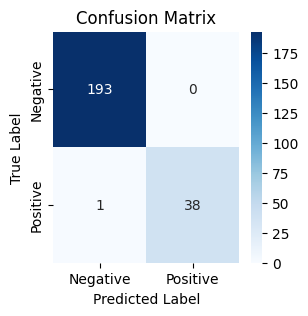

[TN   FP]
[FN   TP]
True Negatives (TN): 193
False Positives (FP): 0
False Negatives (FN): 1
True Positives (TP): 38
False Negative Rate (FNR = FN / (FN + TP)): 2.56%


In [28]:
print('\n===================== Step 1: Data Extraction =====================')
df = pd.read_csv('./messages.csv', encoding='utf-8', encoding_errors='ignore')
X_train, X_val, X_test, Y_train, Y_val, Y_test = data_extraction(df)
print('Total number of data:          ', str(len(X_train) + len(X_test) + len(X_val)))
print('Number of data for training:    ' + str(len(X_train)))
print('Number of data for testing:     ' + str(len(X_test)))
print('Number of data for validation: ', str(len(X_val)))
X_train_shadow, Y_train_shadow  = copy_dataset_by_similarity(X_train, Y_train, 0.2)

    
# Target modal
T_FE_method= 'tfidf'
T_classifier= 'SVM'
T_tr_set, T_v_set, T_clf, T_x_train_features, T_feature_names, T_feature_model, T_scalar = train_classifier(T_FE_method, T_classifier, X_train, X_val, X_test, Y_train, Y_val, Y_test)

### **3. Train Shadow Model & Adversarial Attack** ###

In [36]:
def adversarial_attack(S_clf, S_x_train_features, S_tr_set, S_v_set, S_feature_names, X_train, X_val, X_test, Y_train, Y_val, Y_test): 
    print('\n===================== Step 5: PGD Attack ===========================')
    # Run PGD attacks on the trained classifier with 100 spam emails.
    lb = np.ndarray.min(S_x_train_features.toarray())
    ub = np.ndarray.max(S_x_train_features.toarray())
    attack_amount = 100
    PGD_dmax = 0.06
    result, cnt, ad_success_x, ori_dataframe, ori_examples2_y, successful_rate = pgd_attack(S_clf, S_tr_set, S_v_set, Y_val, S_feature_names, attack_amount, PGD_dmax, lb, ub)

    print('\n===================== Step 6: Magic Words ===========================')
    words14str, spam, ham, spam_test = magical_word(X_train, X_val, X_test, Y_train, Y_val, Y_test, result, cnt)
    print(words14str)

    return words14str, spam, ham, spam_test

Number of data for shadow:  1665

===================== Step 2: Preprocessing ========================
Remove hyperlink...
Merge into one line...
Convert to lowercase...
Remove number...
Remove punctuation...
Remove whitespace...
Word Tokenize...
Remove stop words...
Lemmatize...

===================== Step 3: Feature Extraction ===================
2023-11-15 23:07:11,697 - py.warnings - WARNING - c:\users\31360\appdata\local\programs\python\python37\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


===================== Step 4: Training Classifier ==================
Start training SVM:
The best training parameters are:  [('C', 1)]
Validation Accuracy: 99.56896551724138%


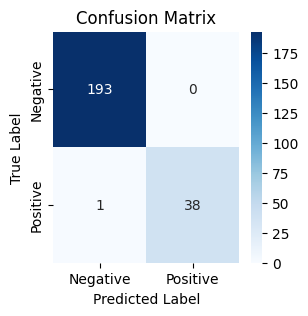

[TN   FP]
[FN   TP]
True Negatives (TN): 193
False Positives (FP): 0
False Negatives (FN): 1
True Positives (TP): 38
False Negative Rate (FNR = FN / (FN + TP)): 2.56%

===================== Step 5: PGD Attack ===========================
Success rate of PGD(validation): 13.00%

===================== Step 6: Magic Words ===========================
 query arizona benjamin workshop ipa chorus au glot linguist academic linguistic native french elra euralex marvelous translation sentence particularly teaching context squib gala cascadilla pkzip ldc theory latin posting
Number of magic words: 29
Set of magic words:
 ['query', 'arizona', 'benjamin', 'workshop', 'ipa', 'chorus', 'au', 'glot', 'linguist', 'academic', 'linguistic', 'native', 'french', 'elra', 'euralex', 'marvelous', 'translation', 'sentence', 'particularly', 'teaching', 'context', 'squib', 'gala', 'cascadilla', 'pkzip', 'ldc', 'theory', 'latin', 'posting']

============== Step 7: Crafting Adversarial Emails & Attacking SVM ======

RuntimeError: threads can only be started once

In [39]:
# Shadow model
X_train_shadow, Y_train_shadow  = copy_dataset_by_similarity(X_train, Y_train, 1)
print('Number of data for shadow: ', str(len(X_train_shadow)))

S_FE_method= 'tfidf'
S_classifier= 'SVM'
S_tr_set, S_v_set, S_clf, S_x_train_features, S_feature_names, S_feature_model, S_scalar = train_classifier(S_FE_method, S_classifier, X_train_shadow, X_val, X_test, Y_train_shadow, Y_val, Y_test)

words14str, spam, ham, spam_test = adversarial_attack(S_clf, S_x_train_features, S_tr_set, S_v_set, S_feature_names, X_train_shadow, X_val, X_test, Y_train_shadow, Y_val, Y_test)
magic_words = words14str.lstrip().split(' ')
print('Number of magic words:', len(magic_words))
print('Set of magic words:\n', magic_words)

print('\n============== Step 7: Crafting Adversarial Emails & Attacking SVM ===============')
# we craft a set of spam emails and feed them to the trained classifier for testing. 
m2_empty = svm_attack(T_FE_method, T_clf, spam_test, words14str, T_feature_model, T_feature_names, T_scalar, 'NaN')  # spam email from test dataset

## **Experience 2**
### **Combine Datasets** ### 

In [ ]:
print('\n============== Step 7: Crafting Adversarial Emails & Attacking SVM ===============')
# we craft a set of spam emails and feed them to the trained classifier for testing. 
m2_empty = svm_attack(T_FE_method, T_clf, spam_test, words14str, T_feature_model, T_feature_names, T_scalar, 'NaN')  # spam email from test dataset

In [ ]:
def adversarial_attack2(T_FE_method, S_FE_method, classifier, df_shadow, PGD_dmax, T_feature_model, T_feature_names, T_scalar):
    print('\n===================== Step 1: Data Extraction =====================')
    X_train, X_val, X_test, Y_train, Y_val, Y_test = data_extraction(df_shadow)
    print('Total number of data:          ', str(len(X_train) + len(X_test) + len(X_val)))
    print('Number of data for training:    ' + str(len(X_train)))
    print('Number of data for testing:     ' + str(len(X_test)))
    print('Number of data for validation: ', str(len(X_val)))
    
    print('\n===================== Step 2: Preprocessing ========================')
    x_train, x_val, x_test = preprocess(X_train, X_val, X_test)
    
    print('\n===================== Step 3: Feature Extraction ===================')
    x_train_features, x_test_features, x_val_features, feature_names, feature_model, scalar = feature_extraction(x_train, x_test, x_val, S_FE_method)
    
    print('\n===================== Step 4: Training Classifier ==================')
    if classifier == 'SVM':
        tr_set, v_set, clf = train_SVM(x_train_features, x_test_features, x_val_features, Y_train, Y_test, Y_val)
    elif classifier == 'LR':
        tr_set, v_set, clf = train_LR(x_train_features, x_test_features, x_val_features, Y_train, Y_test, Y_val)
    else:
        print('Please specify SVM or LR or DT as your classifier.')
        
    print('\n===================== Step 5: PGD Attack ===========================')
    # Run PGD attacks on the trained classifier with 100 spam emails.
    lb = np.ndarray.min(x_train_features.toarray())
    ub = np.ndarray.max(x_train_features.toarray())
    attack_amount = 100
    result, cnt, ad_success_x, ori_dataframe, ori_examples2_y, successful_rate = pgd_attack(clf, tr_set, v_set, Y_val, feature_names, attack_amount, PGD_dmax, lb, ub)
    
    print('\n===================== Step 6: Magic Words ===========================')
    words14str, spam, ham = magical_word(X_train, X_val, Y_train, Y_val, result, cnt)
    print(words14str)

    print('\n============== Step 7: Crafting Adversarial Emails & Attacking SVM ===============')
    # we craft a set of spam emails and feed them to the trained classifier for testing. 
    # It prints out the success rate of this attack.
    m2_empty = svm_attack(T_FE_method, T_clf, spam, words14str, T_feature_model, T_feature_names, T_scalar, 'NaN')  # spam email from test dataset
    
    return words14str

In [ ]:
# Shadow model
S_FE_method= 'word2vec'
S_classifier= 'SVM'

# adversarial attack
PGD_dmax = 0.06
words14str = adversarial_attack(T_FE_method, S_FE_method, S_classifier, df_shadow, PGD_dmax, T_feature_model, T_feature_names, T_scalar)
magic_words = words14str.lstrip().split(' ')
print('Number of magic words:', len(magic_words))
print('Set of magic words:\n', magic_words)